Total energy now contains local density-density interactions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float32
device = "cpu"

M_cutoff = 50 # maximum harmonic
N_grid   = 512 # number of grid points
m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
#design matrix needed to sample densities
DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
std_harm = 2.0 / (1.0 + m)**2

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 200
lr = 1e-3 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training
sigma_Gaussian = 1.0 # width of Gaussian kernel for interaction energy

Setup the functional and sample density profiles 

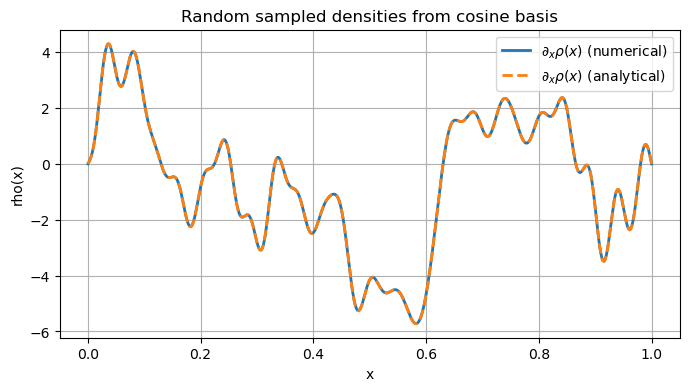

E_loc shape: torch.Size([32]), first few: tensor([0.0112, 0.4165, 0.2939, 0.1458, 0.1055, 0.1490, 0.0270, 0.2976, 0.2584,
        0.1377])
E_kin shape: torch.Size([32]), first few: tensor([0.9090, 5.7351, 4.1125, 3.1131, 2.8535, 2.0741, 1.9449, 4.2978, 3.4896,
        4.0770])
E_int_v0 shape: torch.Size([32]), first few: tensor([0.0295, 1.0978, 0.7780, 0.3867, 0.2770, 0.3921, 0.0709, 0.7868, 0.6791,
        0.3612])
E_int_v1 shape: torch.Size([32]), first few: tensor([0.0295, 1.0978, 0.7780, 0.3867, 0.2770, 0.3921, 0.0709, 0.7868, 0.6791,
        0.3612])
E_int_conv shape: torch.Size([32]), first few: tensor([0.0295, 1.0978, 0.7780, 0.3867, 0.2770, 0.3921, 0.0709, 0.7868, 0.6791,
        0.3612])
Difference between E_int_v0 and E_int_v1 (should be zero):
tensor(1.7285e-05)
Difference between E_int_v1 and E_int_conv (should be zero):
tensor(1.1921e-07)


In [2]:
def sample_density(*, rho_b=0.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density has zero mean over the grid points
    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix
    d_rho_a = a @ DerDM  # derivative of rho w.r.t. x

    rho = rho - rho.mean()


    return rho, d_rho_a

def sample_density_batch(B: int, rho_b=0.0):
    """
    Sample a batch of B density profiles
    Spatial average density rho_avg is set to zero
    Returns rho: (B, N_grid)
    """
    a = torch.normal(torch.zeros(B, std_harm.numel()), std_harm.expand(B, -1))
    rho = a @ DesignMatrix  # (B, N_grid)
    d_rho_a = a @ DerDM  # (B, N_grid) # derivative of rho w.r.t. x

    rho = rho - rho.mean(dim=1, keepdim=True)
    return rho, d_rho_a

def density_derivative(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute d_rho_j = (rho_{j+1} - rho_{j-1})/2 on a unit-lattice grid.
    Boundary conditions: d_rho_0 = d_rho_{N-1} = 0.

    Args:
        rho: (..., N_grid) tensor. Works for shape (N,) or (B, N).

    Returns:
        d_rho: same shape as rho.
    """
    d = torch.zeros_like(rho)
    d[..., 1:-1] = (N_grid - 1) * 0.5 * (rho[..., 2:] - rho[..., :-2])  # centered difference
    # boundaries remain zero by construction
    return d

def E_loc(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute local energy -- custom functional
    rho: (N,) or (B, N)
    Returns: (N,) or (B, N)
    """
    return (rho + rho**2).sum(dim=-1) / N_grid

def E_kin(d_rho: torch.Tensor) -> torch.Tensor:
    """
    Compute kinetic energy -- custom functional
    d_rho: (N,) or (B, N) - spatial derivative of rho
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return 0.5 * (d_rho**2).sum(dim=-1) / N_grid

# density–density interaction kernels K(r)
# r: tensor (can be negative)
def K_gaussian(r, sigma=1.0):       # strictly local-ish
    r = r.to(dtype=torch.get_default_dtype())
    return torch.exp(-(r**2) / (sigma**2))

def K_exp(r, xi=2.0):              # short–to–intermediate range
    r = r.to(dtype=torch.get_default_dtype())
    return torch.exp(-torch.abs(r) / xi)

def K_yukawa(r, lam=10.0):         # long-range but screened
    r = torch.abs(r).to(dtype=torch.get_default_dtype())
    r = r.clamp(min=1.0)         # avoid r=0 singularity
    return torch.exp(-r / lam) / r

def K_power(r, alpha=1.0):         # unscreened long range (Coulomb-like for alpha=1)
    r = torch.abs(r).to(dtype=torch.get_default_dtype())
    r = r.clamp(min=1.0)
    return 1.0 / (r**alpha)

def E_int_brute_force_v0(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor:
    """
    Compute interaction energy by brute force double sum
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K = K_gaussian
    elif kernel == "exp":
        K = K_exp
    elif kernel == "yukawa":
        K = K_yukawa
    elif kernel == "power":
        K = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    E = torch.zeros(B, device=device, dtype=dtype)
    for i in range(N):
        for j in range(N):
            r_ij = torch.tensor(i - j, device=device, dtype=dtype)
            K_ij = K(r_ij, **kwargs)      # scalar tensor
            E += 0.5 * K_ij * rho[:, i] * rho[:, j]
    return E / N


def E_int_brute_force_v1(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor:
    """
    Brute-force reference:
        E_int = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j}
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function (sigma, xi, lam, alpha, etc.)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K_fun = K_gaussian
    elif kernel == "exp":
        K_fun = K_exp
    elif kernel == "yukawa":
        K_fun = K_yukawa
    elif kernel == "power":
        K_fun = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    # ensure batch dim
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    # distance matrix r_{ij} = i - j
    idx = torch.arange(N, device=device, dtype=dtype)
    r = idx.unsqueeze(0) - idx.unsqueeze(1)    # (N, N)

    # kernel matrix K_{ij} = K(i-j)
    K_mat = K_fun(r, **kwargs)                # (N, N)

    # E_b = 1/(2N) sum_{i,j} rho_{b,i} K_{ij} rho_{b,j}
    E = 0.5 * torch.einsum('bi,ij,bj->b', rho, K_mat, rho) / N  # (B,)

    return E.squeeze(0) if E.numel() == 1 else E

def E_int_conv(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor: 
    """
    Interaction energy using convolution
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function (sigma, xi, lam, alpha, etc.)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K_fun = K_gaussian
    elif kernel == "exp":
        K_fun = K_exp
    elif kernel == "yukawa":
        K_fun = K_yukawa
    elif kernel == "power":
        K_fun = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    # ensure batch dim
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    # r = -(N-1)..(N-1), kernel length = 2N-1
    r_vals = torch.arange(-(N-1), N, device=device, dtype=dtype)  # (2N-1,)
    k_full = K_fun(r_vals, **kwargs)                              # (2N-1,)

    weight = k_full.view(1, 1, -1)                # (1,1,2N-1)
    u = F.conv1d(rho.unsqueeze(1), weight, padding=N-1).squeeze(1) # (B, N)
    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


def E_tot(rho: torch.Tensor, d_rho: torch.Tensor) -> torch.Tensor:
    """
    Total energy = local + kinetic + interaction
    rho: (N,) or (B, N)
    d_rho: (N,) or (B, N)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return E_loc(rho) + E_kin(d_rho) + E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian)


# generate one sample
rho_batch, d_rho_batch_analytical = sample_density_batch(32)  # (B, N_grid)
d_rho_batch = density_derivative(rho_batch)  # (B, N_grid)

k = 3
# plot
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), d_rho_batch[k, :].numpy(), lw=2, label=r"$\partial_x \rho(x)$ (numerical)")
plt.plot(x.numpy(), d_rho_batch_analytical[k, :].numpy(), lw=2, label=r"$\partial_x \rho(x)$ (analytical)", ls="--")
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.legend()
plt.show()

# Compute energies
E_loc_batch = E_loc(rho_batch)
E_kin_batch = E_kin(d_rho_batch)
E_int_v0_batch = E_int_brute_force_v0(rho_batch, kernel="gaussian", sigma=3.0)
E_int_v1_batch = E_int_brute_force_v1(rho_batch, kernel="gaussian", sigma=3.0)
E_int_conv_batch = E_int_conv(rho_batch, kernel="gaussian", sigma=3.0)

# Print 
print(f"E_loc shape: {E_loc_batch.shape}, first few: {E_loc_batch[:10]}")
print(f"E_kin shape: {E_kin_batch.shape}, first few: {E_kin_batch[:10]}")
print(f"E_int_v0 shape: {E_int_v0_batch.shape}, first few: {E_int_v0_batch[:10]}")
print(f"E_int_v1 shape: {E_int_v1_batch.shape}, first few: {E_int_v1_batch[:10]}")
print(f"E_int_conv shape: {E_int_conv_batch.shape}, first few: {E_int_conv_batch[:10]}")

print("Difference between E_int_v0 and E_int_v1 (should be zero):")
print((E_int_v0_batch - E_int_v1_batch).abs().max())
print("Difference between E_int_v1 and E_int_conv (should be zero):")
print((E_int_v1_batch - E_int_conv_batch).abs().max())


Feature processing (generation and normalization)

In [3]:
# we save features as (B, N_grid, N_feat), where N_feat is the number of features per grid point
# generate train/test split

def compute_normalization_stats(features):
    """
    Compute mean and std for features with shape (N_data, N_grid, N_feat)
    Averages over both data and spatial dimensions
    
    Args:
        features: torch.Tensor of shape (N_data, N_grid, N_feat)
    
    Returns:
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)
    """

    mean_feat = features.mean(dim=(0, 1), keepdim=True)  # Shape: (1, 1, N_feat)
    std_feat = features.std(dim=(0, 1), keepdim=True) # Shape: (1, 1, N_feat)
    
    return mean_feat, std_feat

def normalize_features(features, mean_feat, std_feat):
    """
    Normalize features using provided or computed statistics
    
    Args:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)

    Returns:
        normalized_features: torch.Tensor of same shape as input
        mean: mean used for normalization
        std: std used for normalization
    """
    normalized_features = (features - mean_feat) / std_feat

    return normalized_features

def generate_loc_features_rs(rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density rho
    rs, real space   
    Args:
        rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form rho^k, k=1,...,N_feat
    """
    features = [rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

def generate_loc_features_ms(d_rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density derivative d_rho
    ms, momentum space
    Args:
        d_rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form d_rho^k, k=1,...,N_feat
    """
    features = [d_rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

torch.random.manual_seed(1234) # for reproducibility

rho_train, d_rho_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test, d_rho_test = sample_density_batch(N_test)   # (N_test, N_grid)
rho_val, d_rho_val = sample_density_batch(N_val)    # (N_val, N_grid)

N_feat = 2 

features_train_rs = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_rs  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_rs   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train_ms = generate_loc_features_ms(d_rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_ms  = generate_loc_features_ms(d_rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_ms   = generate_loc_features_ms(d_rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train = torch.cat([features_train_rs, features_train_ms], dim=-1)
features_test  = torch.cat([features_test_rs, features_test_ms], dim=-1)
features_val   = torch.cat([features_val_rs, features_val_ms], dim=-1)

# # Use only real space features, no derivatives
# features_train = features_train_rs
# features_test  = features_test_rs
# features_val   = features_val_rs

targets_train = E_tot(rho_train, d_rho_train)            # (N_train,)
targets_test  = E_tot(rho_test, d_rho_test)             # (N_test,)
targets_val   = E_tot(rho_val, d_rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

In [4]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi


# Define the neural network models
class LocalEngDensityNN(nn.Module):
    """
    A neural network for predicting energy density from a local feature vector.
    """
    # N_feat: the total number of features per grid point [rho_i, rho_i^2, ..., dx_rho_i, dx_rho_i^2, ..., phi_{i,1}, ... ] 
    def __init__(self, N_feat=1, hidden_dim=128, n_hidden=2): 
        super().__init__()
        layers = []
        layers.append(nn.Linear(N_feat, hidden_dim))
        layers.append(nn.GELU())
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.GELU())
        
        layers.append(nn.Linear(hidden_dim, 1))  # scalar output

        self.net = nn.Sequential(*layers)
        self.N_feat = N_feat
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden

    def forward(self, features):
        # features: (B, N_grid, N_feat)
        output = self.net(features)
        return output.squeeze(-1)
    
class TotalEnergyNN(nn.Module):
    """ 
    A neural network model to predict total energy from local features
    Learnable convolution kernel + local energy density NN
    """
    def __init__(self, N_feat=1, hidden_dim=128, n_hidden=2, R=5):
        super().__init__()
        self.local_energy_net = LocalEngDensityNN(N_feat, hidden_dim, n_hidden)
        self.N_feat = N_feat
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")
        
    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat)
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho = features[..., 0]          # (B, N_grid), isolate density
        # apply learnable convolution kernel
        rho_conv = self.kernel_conv(rho)  # (B, N_grid)
        # add convolved density as additional feature
        features = torch.cat([features, rho_conv.unsqueeze(-1)], dim=-1)  # (B, N_grid, N_feat + 1)

        local_energies = self.local_energy_net(features)        # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,)
        
        return local_energies, total_energy
    
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            _, y_pred = model(xb)
            loss = criterion(y_pred, yb)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

def load_checkpoint(path, model_class, device="cpu"):
    """
    Loads a saved model checkpoint
    Returns:
        model: reconstructed and loaded model
        normalization: dict of normalization stats
        epoch: best epoch
        val_loss: best validation loss
    """
    ckpt = torch.load(path, map_location=device)
    config = ckpt["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    normalization = ckpt.get("normalization", None)
    epoch = ckpt.get("epoch", None)
    val_loss = ckpt.get("val_loss", None)
    return model, normalization, epoch, val_loss
    
def _run_epoch(model, loader, criterion, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    running = 0.0
    n_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train:
                optimizer.zero_grad()

            _, total_pred = model(xb)               
            loss = criterion(total_pred, yb)        

            if train:
                loss.backward()
                optimizer.step()

            running += loss.item()
            n_batches += 1

    return running / max(1, n_batches)

def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    max_epochs=10000,
    patience=10,
    min_delta=1e-5,
    ckpt_dir="checkpoints",
    run_name=None,
):
    os.makedirs(ckpt_dir, exist_ok=True)

    best_val = math.inf
    best_state = None
    best_epoch = -1
    since_improved = 0

    hist = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        train_loss = _run_epoch(model, train_loader, criterion, train=True)
        val_loss = _run_epoch(model, val_loader, criterion, train=False)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        improved = (best_val - val_loss) > min_delta
        if improved:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            since_improved = 0

            # save checkpoint with normalization stats
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_best.pt")
            torch.save({
                "model_state_dict": best_state,
                "epoch": best_epoch,
                "val_loss": best_val,
                "config": {
                    "N_feat": model.N_feat,
                    "hidden_dim": model.hidden_dim,
                    "n_hidden": model.n_hidden,
                    "R": model.R,
                },
                "normalization": {
                    "mean_feat": mean_feat.cpu(),
                    "std_feat":  std_feat.cpu(),
                    "E_mean":    E_mean.cpu(),
                    "E_std":     E_std.cpu(),
                    "N_grid":    int(N_grid),
                }
            }, ckpt_path)
        else:
            since_improved += 1

        if (epoch % 10) == 0 or epoch == 1:
            print(f"[{epoch:04d}] train={train_loss:.6f} | val={val_loss:.6f} "
                  f"| best_val={best_val:.6f} (epoch {best_epoch})")

        if since_improved >= patience:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch}).")
            break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    csv_path = os.path.join(ckpt_dir, f"{run_name}_history.csv")
    try:
        import csv
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["epoch", "train_loss", "val_loss"])
            for i, (tr, va) in enumerate(zip(hist["train_loss"], hist["val_loss"]), start=1):
                w.writerow([i, tr, va])
    except Exception as e:
        print(f"[warn] could not write CSV: {e}")

    return hist, best_epoch


num_nodes_per_layer_list = [200] # [20, 40, 80, 160, 320]
num_hidden_layers_list = [2] #[2, 4, 6, 8]
R_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for hidden_dim in num_nodes_per_layer_list:
    for n_hidden in num_hidden_layers_list:
        for R in R_list:

            run_name = f"FullLocalModel_h{hidden_dim}_nh{n_hidden}_Nfeat{N_feat}_R{R}_sigma{sigma_Gaussian}" 
            torch.manual_seed(1234) # for reproducibility
            # Training with early stopping and model checkpointing

            model = TotalEnergyNN(N_feat=features_train.shape[-1] + 1, hidden_dim=hidden_dim, n_hidden=n_hidden, R=R).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Reduce LR when val loss plateaus
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
            )

            hist, best_epoch = train_with_early_stopping(
                model,
                train_loader,
                val_loader,
                criterion,
                scheduler=scheduler,
                max_epochs=N_epochs,
                patience=patience,
                min_delta=min_delta,
                ckpt_dir="checkpoints",
                run_name=run_name,
            )
        


[0001] train=0.278658 | val=0.068783 | best_val=0.068783 (epoch 1)
[0010] train=0.000274 | val=0.000311 | best_val=0.000200 (epoch 9)
[0020] train=0.000064 | val=0.000023 | best_val=0.000027 (epoch 19)
[0030] train=0.000039 | val=0.000014 | best_val=0.000014 (epoch 30)
[0040] train=0.000023 | val=0.000042 | best_val=0.000014 (epoch 30)
[0050] train=0.000019 | val=0.000021 | best_val=0.000014 (epoch 30)
[0060] train=0.000046 | val=0.000030 | best_val=0.000014 (epoch 30)
Early stopping at epoch 60 (best @ 30).
[0001] train=0.340706 | val=0.104504 | best_val=0.104504 (epoch 1)
[0010] train=0.000327 | val=0.000219 | best_val=0.000219 (epoch 10)
[0020] train=0.000055 | val=0.000027 | best_val=0.000034 (epoch 17)
[0030] train=0.000037 | val=0.000019 | best_val=0.000024 (epoch 28)
[0040] train=0.000033 | val=0.000057 | best_val=0.000024 (epoch 28)
[0050] train=0.000035 | val=0.000033 | best_val=0.000024 (epoch 28)
Early stopping at epoch 58 (best @ 28).
[0001] train=0.340782 | val=0.104450 | 

In [9]:
best_val = math.inf
best_hdim = 0
best_nhidden = 0
R_best = 0

for hidden_dim in num_nodes_per_layer_list:
    for n_hidden in num_hidden_layers_list:
        for R in R_list:
            run_name = f"FullLocalModel_h{hidden_dim}_nh{n_hidden}_Nfeat{N_feat}_R{R}_sigma{sigma_Gaussian}" 

            model, normalization, epoch, val_loss = load_checkpoint(f"checkpoints/{run_name}_best.pt", TotalEnergyNN, device=device)

            print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
            if val_loss < best_val:
                best_val = val_loss
                best_hdim = hidden_dim
                best_nhidden = n_hidden
                R_best = R

    print(f"Best model: hidden_dim={best_hdim}, n_hidden={best_nhidden}, R={R_best}, val_loss={best_val:.6f}")

Model FullLocalModel_h200_nh2_Nfeat2_R1_sigma1.0: best val loss = 0.000014 at epoch 30
Model FullLocalModel_h200_nh2_Nfeat2_R2_sigma1.0: best val loss = 0.000024 at epoch 28
Model FullLocalModel_h200_nh2_Nfeat2_R3_sigma1.0: best val loss = 0.000019 at epoch 30
Model FullLocalModel_h200_nh2_Nfeat2_R4_sigma1.0: best val loss = 0.000019 at epoch 25
Model FullLocalModel_h200_nh2_Nfeat2_R5_sigma1.0: best val loss = 0.000019 at epoch 25
Model FullLocalModel_h200_nh2_Nfeat2_R6_sigma1.0: best val loss = 0.000017 at epoch 28
Model FullLocalModel_h200_nh2_Nfeat2_R7_sigma1.0: best val loss = 0.000017 at epoch 28
Model FullLocalModel_h200_nh2_Nfeat2_R8_sigma1.0: best val loss = 0.000016 at epoch 35
Model FullLocalModel_h200_nh2_Nfeat2_R9_sigma1.0: best val loss = 0.000016 at epoch 35
Model FullLocalModel_h200_nh2_Nfeat2_R10_sigma1.0: best val loss = 0.000017 at epoch 30
Best model: hidden_dim=200, n_hidden=2, R=1, val_loss=0.000014


Evaluate performance of training

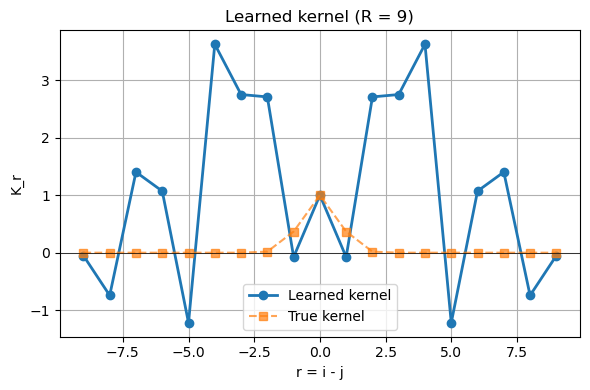

In [31]:
hidden_dim = best_hdim
n_hidden = best_nhidden
R = 9
run_name = f"FullLocalModel_h{hidden_dim}_nh{n_hidden}_Nfeat{N_feat}_R{R}_sigma{sigma_Gaussian}"
model, normalization, epoch, val_loss = load_checkpoint(f"checkpoints/{run_name}_best.pt", TotalEnergyNN, device=device)

with torch.no_grad():
    k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 

r_grid = np.arange(-R, R+1)
k_full


def K_true(r):
    return np.exp(- (r**2) / sigma_Gaussian**2)

k_true = K_true(r_grid)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full / (abs(k_full[R])), 'o-', label='Learned kernel', linewidth=2)
plt.plot(r_grid, k_true / (abs(k_true[R])), 's--', label='True kernel', alpha=0.7)

plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Learned kernel (R = {R})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
r_grid

array([-1,  0,  1])

In [32]:
first_linear = model.local_energy_net.net[0]  # nn.Linear
W = first_linear.weight.detach().cpu().numpy()  # shape: (hidden_dim, N_feat+1)

# index of phi channel is -1 (last feature)
phi_column_norm = np.linalg.norm(W[:, -1])
rho_column_norm = np.linalg.norm(W[:, 0])

print("||weights for phi|| =", phi_column_norm)
print("||weights for rho|| =", rho_column_norm)

||weights for phi|| = 3.5679998
||weights for rho|| = 3.4425008
